In [1]:
import numpy as np
import pandas as pd
import glob

import scipy
import matplotlib.pyplot as plt

import itertools
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot
%matplotlib inline

from shapely.geometry import LineString, MultiLineString, MultiPoint, Point, Polygon, box, MultiPolygon
from shapely.ops import nearest_points, linemerge, unary_union, polygonize
from shapely import affinity

import geopandas as gpd
import geopandas
import pandas
import fiona
import json


from bokeh.io import show, output_notebook
from bokeh.models import (CDSView, ColorBar, LogColorMapper, 
                          ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.palettes import Accent as palette
palette = palette[8]
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

I'm going to put in some effort to generate Proteomaps (voronoi treemaps). Sadly, these maps are not at all trivial to make. Specifically, it isn't obvious how to generate a Voronoi diagram where the size of each cell is proportional to some specified area. With that said, there do appear to be some tools in python (using QHull?) in Scipy that are able to do some of the required calculations to generate a Voronoi diagram. In addition, a paper from. Nocaj and Brandes 2012 suggests a way forward using an iterative approach. I came across this in a recent eLife paper where they generate Proteomaps based on this approach (https://elifesciences.org/articles/36842). Sadly, they do not provide any code. While I could ask them to share, it is unclear whether it will work with our python pipeline (which I think is important overall to our effort). 

Nocaj, A., & Brandes, U. (2012). Computing Voronoi Treemaps: Faster, Simpler, and Resolution‐independent. Computer Graphics Forum, 31(3pt1), 855–864. http://doi.org/10.1111/j.1467-8659.2012.03078.x

TO DOs:
In order to use the proposed algorithm, I need to be able to generate so-called power-weighted Voronoi diagram (also known as Laguerre-Voronoi diagram), which isn't what the Scipy tool does. I have found some code snippets at https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627 that provide some help and might enable me to make progress.

Using the algorithm from Nocaj, A., & Brandes, U. (2012), I need to generate power diagram, convert 
this into polygons, and iterate to get desired cell areas. 
1. Convert the cells into polygons (try using Shapely tool which will make calculating areas and centroids quite simple). Here I also need to intercect with our bounded polygon (i.e. the bounds of the figure)
2. Perform the adaptive weighting to recorrect positions of points, etc
3. iterate as needed - comparing desired volumes to current cell volumes. 

## Code to Calculate Delaunay Triangulation and Lower Convex Hull

In [134]:
# largely taken from; though with some modification.
# https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627#file-laguerre-voronoi-2d-py
    
def norm2(X):
    return np.sqrt(np.sum(X ** 2))

def normalized(X):
    return X / norm2(X)


def get_power_triangulation(S, R):
    # Compute the lifted weighted points -NB: THIS IS THE IMPORTANT PART for the weighting
    S_norm = np.sum(S ** 2, axis = 1) - np.array(R)# ** 2

    S_lifted = np.concatenate([S, S_norm[:,None]], axis = 1)

#     # Special case for 3 points
#     if S.shape[0] == 3:
#         if is_ccw_triangle(S[0], S[1], S[2]):
#             return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
#         else:
#             return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

    # Compute the convex hull of the lifted weighted points
    hull = ConvexHull(S_lifted)

    # Extract the Delaunay triangulation from the lower hull
    tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
    tri_list_ = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] >= 0)

#     # Compute the Voronoi points
#     V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])
#     V_ = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list_])

    return tri_list, tri_list_#, V, V_


# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
    return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))


def get_power_circumcenter(A, B, C):
    N = get_triangle_normal(A, B, C)
    return (-.5 / N[2]) * N[:2]

def is_ccw_triangle(A, B, C):
    M = np.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis = 1)
    return np.linalg.det(M) > 0


# --- Compute Voronoi cells ---------------------------------------------------


def get_voronoi_cells(S, W, tri_list):
    
    '''
    Compute the segments and half-lines that delimits each Voronoi cell
      * The segments are oriented so that they are in CCW order
      * Each cell is a list of (i, j), (A, U, tmin, tmax) where
         * i, j are the indices of two ends of the segment. Segments end points are
           the circumcenters. If i or j is set to None, then it's an infinite end
         * A is the origin of the segment
         * U is the direction of the segment, as a unit vector
         * tmin is the parameter for the left end of the segment. Can be None, for minus infinity
         * tmax is the parameter for the right end of the segment. Can be None, for infinity
         * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
    '''
    S_norm = np.sum(S ** 2, axis = 1) - np.array(W)
    S_lifted = np.concatenate([S, S_norm[:,None]], axis = 1)
    # Compute the Voronoi points
    V = np.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = { i : [] for i in vertices_set }

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
        # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j
                
                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
            else: 
            # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + np.dot(D - A, U) * U
                W = normalized(I - D)
                if np.dot(W, I - C) < 0:
                    W = -W
                    
                # Add the segment
                voronoi_cell_map[u].append(((edge_map[edge][0], np.inf), (D,  W, 0, np.inf)))
                voronoi_cell_map[v].append(((np.inf, edge_map[edge][0]), (D, -W, np.inf, 0)))



    # Order the segments
    def order_segment_list(segment_list):
        # Pick the first element
        first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

        # In-place ordering
        segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
        for i in range(len(segment_list) - 1):
            for j in range(i + 1, len(segment_list)):
                if segment_list[i][0][1] == segment_list[j][0][0]:
                    segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                    break

        return segment_list

    return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }




## Code to Run Algorithm of Nocaj & Brande 2012.

In [135]:
def compute_power_voronoi_map(S, W, border, eps):
    '''
    input: 
    S - Voronoi points/sites
    W - positive real weights associated with Voronoi points
    eps - for shapely conversion of lines to polygon - needed?
    border - bounds of desired map
    
    output:
    tri_list: Delaunay triangulation from the lower hull
    V_cell: Set of polygons forming all Voronoi cells
    
    '''
    # Compute the power triangulation of the circles
    if S.shape[0] > 3:
        tri_list, tri_list_ = get_power_triangulation(S, W)
    

        # Compute the Voronoi cells
        voronoi_cell_map = get_voronoi_cells(S, W, tri_list)
    #         voronoi_cell_map_ = get_voronoi_cells(S, tri_list_)


        # get the lines associated with all the Voronoi cells
        edge_map = { }
        for segment_list in voronoi_cell_map.values():
            for edge, (A, U, tmin, tmax) in segment_list:
                edge = tuple(sorted(edge))
                if edge not in edge_map:
                    if tmax is np.inf:
                        tmax = 20
                    if tmin is np.inf:
                        tmin = -20

                    edge_map[edge] = (A + tmin * U, A + tmax * U)

        V_map = MultiLineString(list(edge_map.values())).buffer(eps)
        
        V_cell = border.difference(V_map)

        while len(S) != len(V_cell):
            V_cell = VoronoiMap_fix(S, V_cell)
            
            
    elif S.shape[0] <= 3:
        S_points = MultiPoint(S[:2]) 
        bisect = affinity.rotate(LineString(S_points), 90, 'center')
        bisect = affinity.scale(bisect, xfact=100, yfact=100)

        borders = unary_union(linemerge([border.boundary, bisect]))
        V_cell = MultiPolygon(polygonize(borders))
        
        while len(S) != len(V_cell):
            V_cell = VoronoiMap_fix(S, V_cell)
                
#     elif S.shape[0] == 2:
#         S_points = MultiPoint(S) 
#         bisect = affinity.rotate(LineString(S_points), 90, 'center')
#         bisect = affinity.scale(bisect, xfact=100, yfact=100)
        
#         borders = unary_union(linemerge([border.boundary, bisect]))
#         V_cell = MultiPolygon(polygonize(borders))
    
    return V_cell


def VoronoiMap_fix(S, V_cell):
    '''
    Use to shift Voronoi sites and adapt weights W 
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    S: Voronoi points
    
    output:
    V_cell_corr - Corrected Voronoi polygons
    '''

    S_points = MultiPoint(S)

    V_cell_ = MultiPolygon([cell for cell in V_cell if ((cell.intersection(S_points)).type  != 'MultiPoint')])
    V_ = MultiPolygon([cell for cell in V_cell if ((cell.intersection(S_points)).type  == 'MultiPoint')])

    while len(V_) >=1:
        for cell in V_:
            V_ = MultiPolygon([P for P in V_ if P != cell])
            # identify the multipe voronoi points in cell
            P = cell.intersection(S_points)
            P_coords = [((p_.xy[0][0], p_.xy[1][0])) for p_ in P]
            for s in P:
                # find point closest to s and split cell using line orthogonal to 
                # their center line
                s_coords = ((s.xy[0][0], s.xy[1][0]))
                s_other = [tuple(s_) for s_ in P_coords if tuple(s_) != tuple(s_coords)]
                NN = nearest_points((s),MultiPoint(s_other))
                bisect = affinity.rotate(LineString(NN), 90, 'center')
                bisect = affinity.scale(bisect, xfact=100, yfact=100)

                borders = unary_union(linemerge([cell.boundary, bisect]))
                cell_split = polygonize(borders)

                for cell_ in cell_split:
                    if ((cell_.intersection(S_points)).type  == 'MultiPoint'):
                        poly=[]
                        for pol in V_:
                            poly.append(pol)
                        poly.append(cell_)
                        V_ = MultiPolygon(poly)
                    else:
                        poly=[]
                        for pol in V_cell_:
                            poly.append(pol)
                        poly.append(cell_)
                        V_cell_ = MultiPolygon(poly)
                break
    return V_cell_


def AdaptPositionsWeights(S, V_cell, W):
    '''
    Use to shift Voronoi sites and adapt weights W 
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    W - positive real weights associated with Voronoi points
    
    output:
    S_new: updated Voronoi points
    W_new: updates weights
    '''
    
    S_ = []
    dist_border = []
    for s in S:
        # identify Voronoi cell associated with s
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell =  cell_ 
        # Move s to centroid of cell
        for pp in cell.centroid.coords: 
            S_.append(pp) 
#             break
        dist_border.append(abs(cell.exterior.distance(Point(pp))))
               
    S_new = np.array(list(map(list, S_)))
    W_new = [np.min([np.sqrt(W[i]),dist_border[i]])**2 for i in np.arange(len(W))]
    
    return S_new, W_new 



def AdaptWeights(V_cell, S, bound, W, w_desired, err = 0.001):
    '''
    Use to adapt weights W
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    S - Voronoi points
    W - positive real weights associated with Voronoi points
    w_desired - desired weighting of each cell
    err - error threshold for values in W; need to understand better.
    
    output:
    W_new: updates weights
    '''
    W_new = []
    
    for i, s in enumerate(S):
        s_other = [tuple(s_) for s_ in S if tuple(s_) != tuple(s)]
        NN = nearest_points(Point(s),MultiPoint(s_other))
        
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell = cell_

        
        A_current = cell.area
        A_desired = bound.area * w_desired[i]
        
        f_adapt = A_desired / A_current
         
        w_new_ = np.sqrt(W[i]) * f_adapt  
#         w_new_ = W[i] * f_adapt  
        w_max = abs(LineString(NN).length)

        W_ = np.min([w_new_, w_max])**2
#         W_new.append(W_)
        W_new.append(np.max([W_, err]))
        
    return W_new

def compute_power_voronoi_map_(S, W, border, eps = 1E-6):
    result = None
    while result is None:
        try:
            V_cell = compute_power_voronoi_map(S, W, border, eps = 1E-6)
            result = True
            return V_cell
            
        except:
            pass
            
def map_iterator(weights, border):
    # number of cells
    sample_count = len(weights)

    # initialize random Voronoi sites and weightings
    # S contains circles center, R = sqrt(W) contains 
    # circles radius for weighting the Voronoi cells
    S_ = random_points_within(border, sample_count)
    S = np.array([([s.x, s.y]) for s in S_])

    W = .8 * np.random.random(sample_count) + .2

    # generate initial Voronoi cells
    V_cell = compute_power_voronoi_map_(S, W, border, eps = 1E-6)

    # Perform iteration on initialized V_cell
    error_diff = np.inf
    error_calc = 100.0
    count = 0
#     while 0 > error_diff >= 0.00001:
    while np.logical_and(error_calc >= 0.08, count <=101):
        print(np.logical_and(error_calc >= 0.08, count <=101))
        print(error_diff, error_calc, count)
        S, W = AdaptPositionsWeights(S, V_cell, W)

        V_cell = compute_power_voronoi_map_(S, W, border, eps = 1E-6)

        W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)

        V_cell = compute_power_voronoi_map_(S, W, border, eps = 1E-6)

        # calculate discrepency between desired cell area and
        # current cell area.
        A_diff = 0
        for i,  s in enumerate(S):
            # identify Voronoi cell associated with s
            for cell_ in V_cell:
                if (Point(s).within(cell_)):
                    cell =  cell_ 
            A_diff += abs(cell.area - border.area * weights[i])

        error_diff = error_calc -  A_diff/(2*border.area)
        error_calc =  A_diff/(2*border.area) 
        count += 1
        

    
    return V_cell

def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        x, y = [np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)]
        random_point = Point([x, y])
        if (random_point.within(poly)):
            points.append([x, y])

    return points


# selection of random initialization points
def disc_uniform_pick(N):
    angle = (2 * np.pi) * np.random.random(N)
    out = np.stack([np.cos(angle), np.sin(angle)], axis = 1)
    out *= np.sqrt(np.random.random(N))[:,None]
    return out

def disc_uniform_pick_2(poly,  num_points, N=1000):
   
    points = []
    
    angle = (2 * np.pi) * np.random.random(N)
    out = np.stack([np.cos(angle), np.sin(angle)], axis = 1)
    out *= np.sqrt(np.random.random(N))[:,None]
    
    for p in out:  
        if (len(points) <=num_points) :
            random_point = Point(p)
            if (random_point.within(poly)):
                    points.append(p)
            
    return points

## Treemap structure - testing on single level

Okay, progress! It looks like the algorithm is roughly working from some initial testing; though it is a little buggy and hangs/errors sometimes. It'll still need some work. 

In any case, lets next try to build a treemap structure that takes in the different proteome sector categories and determines the weightings based on protein abundance. This will be a multi-level structure: we will begin with our main plot bounds (i.e. square box) and generate cells with the higher-level categories; Each cell will then become a new set of bounds to build another set of cells that will house lower-level categories (or individual proteins). I suspect we will want to build seperate diagrams for each lower-level category (where will be the place to show individual genes).

Lets begin with the 'cog_class' categories.

In [136]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')
data = data[data.dataset == 'schmidt_2016']
data = data[data.condition == 'glucose']
cog_dict = dict(zip(data.cog_class.unique(), np.arange(len(data.cog_class.unique()))))

In [119]:
data.head()

,gene_name,b_number,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
5,InsH-1,b0259,glucose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.58,CP4-6 prophage; IS5 transposase and trans-acti...,47.0,0.003068,schmidt_2016,Schmidt et al. 2016,BW25113
25,aas,b2836,glucose,GO:0016874; GO:0016746; GO:0016740; GO:0016020...,metabolism,"secondary metabolites biosynthesis, transport,...",Q,0.58,fused 2-acylglycerophospho-ethanolamine acyltr...,6.0,0.000804,schmidt_2016,Schmidt et al. 2016,BW25113
45,accA,b0185,glucose,GO:0016743; GO:0016740; GO:0042802; GO:0009317...,metabolism,lipid transport and metabolism,I,0.58,acetyl-CoA carboxyltransferase subunit &alpha;,3825.0,0.223769,schmidt_2016,Schmidt et al. 2016,BW25113
65,accB,b3255,glucose,GO:0009305; GO:0005829; GO:0005515; GO:0006631...,metabolism,coenzyme transport and metabolism,H,0.58,biotin carboxyl carrier protein,2574.0,0.071301,schmidt_2016,Schmidt et al. 2016,BW25113
85,accC,b3256,glucose,GO:0005515; GO:0016874; GO:0006631; GO:0006629...,metabolism,lipid transport and metabolism,I,0.58,biotin carboxylase,1810.0,0.148190,schmidt_2016,Schmidt et al. 2016,BW25113


In [120]:
# compute fractional abundance

frac = pd.DataFrame()
# generate desired area weightings
for cog, d in data.groupby('cog_class'):
    frac_ = d.fg_per_cell.sum()/ data.fg_per_cell.sum()
    frac = frac.append({'mass_frac':frac_,
                       'cog_class': cog,
                       'cog_dict' : cog_dict[d.cog_class.unique()[0]]}, ignore_index=True )

In [134]:
# initialize random Voronoi sites and weightings
# S contains circles center, R contains circles radius for weighting the Voronoi cells
# sample_count = 5 #len(frac)
sample_count = len(frac)
S = 5 * disc_uniform_pick(sample_count)
W = .8 * np.random.random(sample_count) + .2

## initialize Laguerre-Voronoi diagram
tri_list,  tri_list_ = get_power_triangulation(S, W)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(S, W, tri_list)

eps = 0.0000001
# eps = 1E-6
# weights = np.ones(sample_count)*0.2 #frac.mass_frac.values
weights = frac.mass_frac.values
# weights = np.array([0.6, 0.1, 0.1, 0.3, 0.2])

# border
b_s = 15
border = box(-b_s, -b_s, b_s, b_s)
# err_thresh = 0.1

In [135]:
V_cell = compute_power_voronoi_map(S, W, border, eps)

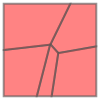

In [136]:
V_cell

In [137]:
# #look at error
# for i, cell in enumerate(V_cell):
#     print(cell.area - (border.area * weights[i]))

for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area/(border.area * weights[i]))

14.282307771414889
1.2244092754950948
0.9260537311450435
0.4244035436447593
2.6348233299397186


In [138]:
# Perform iteration on initialized V_cell
for i in np.arange(100):
    S, W = AdaptPositionsWeights(S, V_cell, W)

    V_cell = compute_power_voronoi_map(S, W, border, eps)

    W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)

    V_cell = compute_power_voronoi_map(S, W, border, eps)

    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i,  s in enumerate(S):
        # identify Voronoi cell associated with s
        for cell_ in V_cell:
            if (Point(s).within(cell_)):
                cell =  cell_ 
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)
    
    print(error_calc)
    print(len(V_cell))


0.29068450804063184
5
0.29532002690072695
5
0.293525758873349
5
0.27110999176619627
5
0.22037815197393995
5
0.16821611120588853
5
0.15394868192435207
5
0.14924102566415579
5
0.15626965929999534
5
0.15276302798663002
5
0.14671425629299506
5
0.14529589134979307
5
0.14252964313234484
5
0.13756324322152605
5
0.1312578298683991
5
0.12675140283023015
5
0.12336066547524316
5
0.1209575792846696
5
0.1194079546272487
5
0.118498077002598
5
0.11801526366653856
5
0.11779337227426985
5
0.11771792157112247
5
0.11771610370604874
5
0.11774483047285426
5
0.11778077213411914
5
0.11781293506695376
5
0.11783745804162304
5
0.11785417161942899
5
0.11786448173952228
5
0.11787018779078758
5
0.1178729121978732
5
0.11787389482797365
5
0.11787397991580786
5
0.11787368625583874
5
0.11787329875694791
5
0.11787295130665844
5
0.11787269007292012
5
0.11787251649696483
5
0.1178724135933388
5
0.11787236028373897
5
0.11787233803444573
5
0.11787233304961793
5
0.11787233622116891
5
0.11787234217491116
5
0.11787234813771254

In [139]:
for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area /(border.area), ( weights[i]))

0.07651592693190877 0.015626864386347458
0.17786596793026502 0.18360224197351155
0.29609023779146354 0.30765184735897405
0.3663846456466423 0.4669591272296937
0.08314321224004975 0.02615991905147321


In [140]:
for i,  s in enumerate(S):
    # identify Voronoi cell associated with s
    for cell_ in V_cell:
        if (Point(s).within(cell_)):
            cell =  cell_ 
    print(cell.area / (border.area * weights[i]))

4.896435077452745
0.9687570588376906
0.9624198272600646
0.7846182337633599
3.1782671833370024


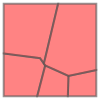

In [141]:
V_cell

In [492]:
# lets plot this!

gdf = pandas.concat([
    geopandas.GeoSeries(cell)
    for cell in V_cell
]).pipe(geopandas.GeoDataFrame)

gdf = gdf.rename(columns = {0:'geometry'})
gdf['cell'] = np.arange(5)
frac['cell'] = np.arange(5)

In [493]:
result = gdf.merge(frac, on=['cell'])

In [494]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = result.to_json())

In [496]:
# Create figure object.
p = figure(title = 'Proteomap', 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
cells = p.patches('xs','ys', source = geosource,
                   line_color = 'black', 
                   line_width = 0.5, 
                   fill_alpha = 0.7,
                   fill_color={'field': color_column,
            'transform': LogColorMapper(palette=palette)} )
# Create hover tool
p.add_tools(HoverTool(renderers = [cells],
                      tooltips = [('Cell','@cell'),
                                 ('COG Category', '@cog_class')]))
show(p)

## Implementing Entire Proteomap Structure

It looks like things are working (mostly). Some errors still come up that need to be dealth with; and I think I still need to look into how to better obtain the lower Convex Hull.

Now lets try to implement the entire treemap. For now I'd like to have a tree structure of COG class -> COG category -> protein; with cell size dictated by total mass of the category. Note that it will likely make sense to ignore proteins that are below some threshold fraction (since it will not be possible to view these in the map.  

In addiiton, it will be nice to build seperate maps for the sub-categories since it'll be difficult to actually see most individual proteins. 

Steps:
1. Build higher level voronoi map for COG class
2. Within each cell, build maps for COG category
3. Within each of these cells, build maps for protein abundance

In [38]:
tree_structure = ['cog_class', 'cog_category', 'gene_name']

In [39]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

# consider only M9 glucose, schmidt 
data = data[data.dataset == 'schmidt_2016']
data = data[data.condition == 'glucose']
cog_dict = dict(zip(data.cog_class.unique(), np.arange(len(data.cog_class.unique()))))

In [36]:
b_s = 15
border = box(-b_s, -b_s, b_s, b_s) 
area_whole = border.area

In [274]:
# proteomap_df = gpd.read_file("../../data/voronoi_map_data/treemap_Schmidt_glucose.geojson", driver='GeoJSON')


In [99]:

for tree_i, tree in enumerate(tree_structure):
    print(tree_i)
    if tree_i == 0:
        continue
    if tree_i == 1:
        continue

    for cat, cell in proteomap_df[proteomap_df['level'] == tree_i-1].groupby(tree_structure[tree_i-1]):  
        print(cat)
        if cat == 'Not Assigned':
            continue
#             tree == 'gene_name'
#             tree_i = 2
#         else:
#             continue

        data_tree = data[data[tree_structure[(tree_i-1)]] == cat]

        border = cell.geometry[cell.index[0]]

        # compute desired cell weightings
        frac = pd.DataFrame()
        for cat_, d in data_tree.groupby(tree_structure[(tree_i)]):
    #                 print(cat, cat_)
            frac_ = d.fg_per_cell.sum()/ data_tree.fg_per_cell.sum()
            frac = frac.append({'mass_frac':frac_,
                               'cog_category' : d.cog_category.unique()[0],
                               'cog_class' : d.cog_class.unique()[0],
                               'cog_dict' : cog_dict[d.cog_class.unique()[0]],
#                                 'gene_name' : None
                                'gene_name' : d.gene_name.unique()[0]
                               }, ignore_index=True )

        # don't attemp to make cells for very low abundant items
        frac = frac[frac.mass_frac >= 0.01]

        # set index for each cell
        frac['index'] = np.arange(len(frac))

        # desired cell weighting
        weights = frac.mass_frac.values
        error_calc = np.inf
        count = 0

        while (error_calc >= 0.1) and (count <=15):
            print(error_calc, count, cat)
            # give 15 tries  and take the map with lowest error
            count += 1      

            try:   
                # number of cells
                sample_count = len(frac)

                S_ = random_points_within(border,  sample_count)
                S = np.array(list(map(list, S_)))
                W = (.8 * np.random.random(sample_count) + .2) * (border.area / area_whole)

                eps = 0.0000001

                # generate initial Voronoi cells
                V = compute_power_voronoi_map(S, W, border, 1E-7)

                # 30 iterations is usually plenty to reach minimum
                for i in np.arange(30):
                    S, W = AdaptPositionsWeights(S, V, W)

                    V = compute_power_voronoi_map(S, W, border, 1E-7)

                    W = AdaptWeights(V, S, border, W, weights, err = 1E-5)

                    V = compute_power_voronoi_map(S, W, border, 1E-7)

                # calculate discrepency between desired cell area and
                # current cell area.
                # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
                # so this needs some work
                A_diff = 0
                for i,  s in enumerate(S):
                    # identify Voronoi cell associated with s
                    for cell_ in V:
                        if (Point(s).within(cell_)):
                            cell =  cell_ 
                    A_diff += abs(cell.area - border.area * weights[i])
    #             print(error_calc)
                if A_diff/(2*border.area) < error_calc:
                    V_cell = V
                    S_final = S

                # update error value
                error_calc =  A_diff/(2*border.area)
                print(error_calc)

            except:
                pass

        if error_calc != np.inf:
            gdf = pd.concat([gpd.GeoSeries(cell_) for s in S_final 
                                 for cell_ in V_cell 
                                 if Point(s).within(cell_)
                                ]).pipe(gpd.GeoDataFrame)
            gdf = gdf.rename(columns = {0:'geometry'})
            gdf['index'] = np.arange(len(frac))
            gdf['level'] = tree_i

            proteomap_df = proteomap_df.append(gdf.merge(frac, on=['index']))
        else:
            print('Did not find map for:' + cat)


0
1
2
Replication, recombination, and repair
inf 0 Replication, recombination, and repair
0.11557701372188076
0.11557701372188076 1 Replication, recombination, and repair
0.08900808553728635
amino acid transport and metabolism
inf 0 amino acid transport and metabolism


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in subtract
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


0.13347327973704476
0.13347327973704476 1 amino acid transport and metabolism
0.13347327973704476 2 amino acid transport and metabolism
0.1375450701342671
0.1375450701342671 3 amino acid transport and metabolism
0.13401562083163404
0.13401562083163404 4 amino acid transport and metabolism
0.13401562083163404 5 amino acid transport and metabolism
0.13401562083163404 6 amino acid transport and metabolism
0.13401562083163404 7 amino acid transport and metabolism
0.1334732802799053
0.1334732802799053 8 amino acid transport and metabolism
0.135336986284904
0.135336986284904 9 amino acid transport and metabolism
0.14028969823283338
0.14028969823283338 10 amino acid transport and metabolism
0.1334732795807889
0.1334732795807889 11 amino acid transport and metabolism
0.14066938552499542
0.14066938552499542 12 amino acid transport and metabolism
0.13426697842608523
0.13426697842608523 13 amino acid transport and metabolism
0.13987022990950007
0.13987022990950007 14 amino acid transport and meta

/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in subtract
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


0.10200864694006197
0.10200864694006197 14 energy production and conversion
0.10200864694006197 15 energy production and conversion
0.10300977964989476
function unknown
inf 0 function unknown
inf 1 function unknown
inf 2 function unknown
0.08439952051810436
general function prediction only
inf 0 general function prediction only
0.14360649399703196
0.14360649399703196 1 general function prediction only
0.13035631794442765
0.13035631794442765 2 general function prediction only
0.12720864893139291
0.12720864893139291 3 general function prediction only
0.1302623123803826
0.1302623123803826 4 general function prediction only
0.1271998673924844
0.1271998673924844 5 general function prediction only
0.1327945005963888
0.1327945005963888 6 general function prediction only
0.12704806507758515
0.12704806507758515 7 general function prediction only
0.12748665358920527
0.12748665358920527 8 general function prediction only
0.1297554683125713
0.1297554683125713 9 general function prediction only
0.1

/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


inf 0 posttranslational modification, protein turnover, chaperones
inf 1 posttranslational modification, protein turnover, chaperones
0.09823892260190487
secondary metabolites biosynthesis, transport, and catabolism
inf 0 secondary metabolites biosynthesis, transport, and catabolism
0.09536699253791404
signal transduction mechanisms


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


inf 0 signal transduction mechanisms
inf 1 signal transduction mechanisms
0.08672131729033916
transcription
inf 0 transcription
0.08806949343748995
translation, ribosomal structure and biogenesis
inf 0 translation, ribosomal structure and biogenesis
inf 1 translation, ribosomal structure and biogenesis
0.16781033767902753
0.16781033767902753 2 translation, ribosomal structure and biogenesis


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in subtract
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


0.1663431675105014
0.1663431675105014 3 translation, ribosomal structure and biogenesis
0.1663431675105014 4 translation, ribosomal structure and biogenesis
0.17708251817104018
0.17708251817104018 5 translation, ribosomal structure and biogenesis
0.16201584042760947
0.16201584042760947 6 translation, ribosomal structure and biogenesis
0.1619379952139453
0.1619379952139453 7 translation, ribosomal structure and biogenesis
0.16202143420084708
0.16202143420084708 8 translation, ribosomal structure and biogenesis
0.16209164182046054
0.16209164182046054 9 translation, ribosomal structure and biogenesis
0.16209164182046054 10 translation, ribosomal structure and biogenesis
0.16193799591863958
0.16193799591863958 11 translation, ribosomal structure and biogenesis
0.1833132233137099
0.1833132233137099 12 translation, ribosomal structure and biogenesis
0.1620270276135957
0.1620270276135957 13 translation, ribosomal structure and biogenesis
0.16291700395202469
0.16291700395202469 14 translation,

In [102]:
geosource_ = GeoJSONDataSource(geojson = proteomap_df.to_json())
# proteomap_df.to_file("../../data/voronoi_map_data/treemap_Schmidt_glucose.geojson", driver='GeoJSON')

In [101]:
color_column = 'cog_dict'

# Create figure object.
p = figure(title = 'Proteomap', 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

cells = p.patches('xs','ys', source = geosource_,
                   line_color = 'black', 
                   line_width = 0.5, 
                   fill_alpha = 0.2,
                   fill_color={'field': color_column,
            'transform': LogColorMapper(palette=palette)} )

# Create hover tool
p.add_tools(HoverTool(renderers = [cells],
                      tooltips = [('COG Class', '@cog_class'),
                                  ('COG Category', '@cog_category'),
                                  ('Gene name', '@gene_name')]))
show(p)

In [9]:
proteomap_df_ref = \
    gpd.read_file("../../data/voronoi_map_data/treemap_li_2014_MOPS complete_1.93_ref_.geojson",
                                     driver='GeoJSON')

# proteomap_df_ref = \
#     gpd.read_file("../../data/voronoi_map_data/treemap_schmidt_2016_glucose_0.58.geojson",
#                                      driver='GeoJSON')
    
geosource_ = GeoJSONDataSource(geojson = proteomap_df_ref[proteomap_df_ref.level==2].to_json())

In [10]:
color_column = 'cog_dict'

# Create figure object.
p = figure(title = 'Proteomap', 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

cells = p.patches('xs','ys', source = geosource_,
                   line_color = 'black', 
                   line_width = 0.5, 
                   fill_alpha = 0.2,
                   fill_color={'field': color_column,
            'transform': LogColorMapper(palette=palette)} )

# Create hover tool
p.add_tools(HoverTool(renderers = [cells],
                      tooltips = [('COG Class', '@cog_class'),
                                  ('COG Category', '@cog_category'),
                                  ('gene', '@gene_name')]))
show(p)

## Ignore; used for troubleshooting

In [392]:
def display(S, tri_list, voronoi_cell_list):
    # Setup
    fig, ax = plot.subplots()
    plot.axis('equal')
    plot.axis('off')	

    # Plot the samples
    plot.scatter(S[:,0], S[:,1], lw = 0., c = 'k', zorder = 1)

    # Plot the Delaunay triangulation
    edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
    line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.8')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

    # get the lines associated with all the Voronoi cells
    edge_map = { }
    for segment_list in voronoi_cell_list.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is np.inf:
                    tmax = 20
                if tmin is np.inf:
                    tmin = -20

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
    line_list.set_zorder(0)
    ax.add_collection(line_list)

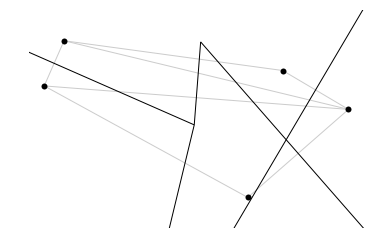

In [411]:
display(S, tri_list_, voronoi_cell_map_)

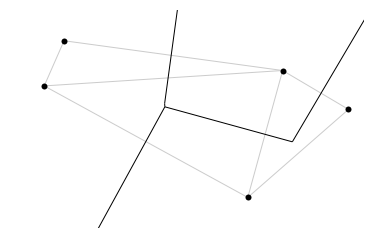

In [412]:
display(S, tri_list, voronoi_cell_map)

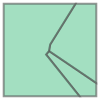

In [393]:
V_cell

In [1034]:
# Perform iteration on initialized V_cell
for i in np.arange(100):
#     print(i)
    S, W = AdaptPositionsWeights(S, V_cell, W)

    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    
    W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)
    
    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    print(len(tri_list))
    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i, cell in enumerate(V_cell):
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)

    print(error_calc)




UnboundLocalError: local variable 'cell' referenced before assignment